In [56]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

os.listdir("chest_xray")

['chest_xray', 'test', 'train', 'val', '__MACOSX']

In [57]:
len(os.listdir("chest_xray/train/PNEUMONIA"))

3875

The dataset is divided into three sets: 1) Train set 2) Validation set and 3) Test set.

# Data Visualization


Train set:
PNEUMONIA=3875
NORMAL=1341
Test set:
PNEUMONIA=390
NORMAL=234
Validation set:
PNEUMONIA=8
NORMAL=8


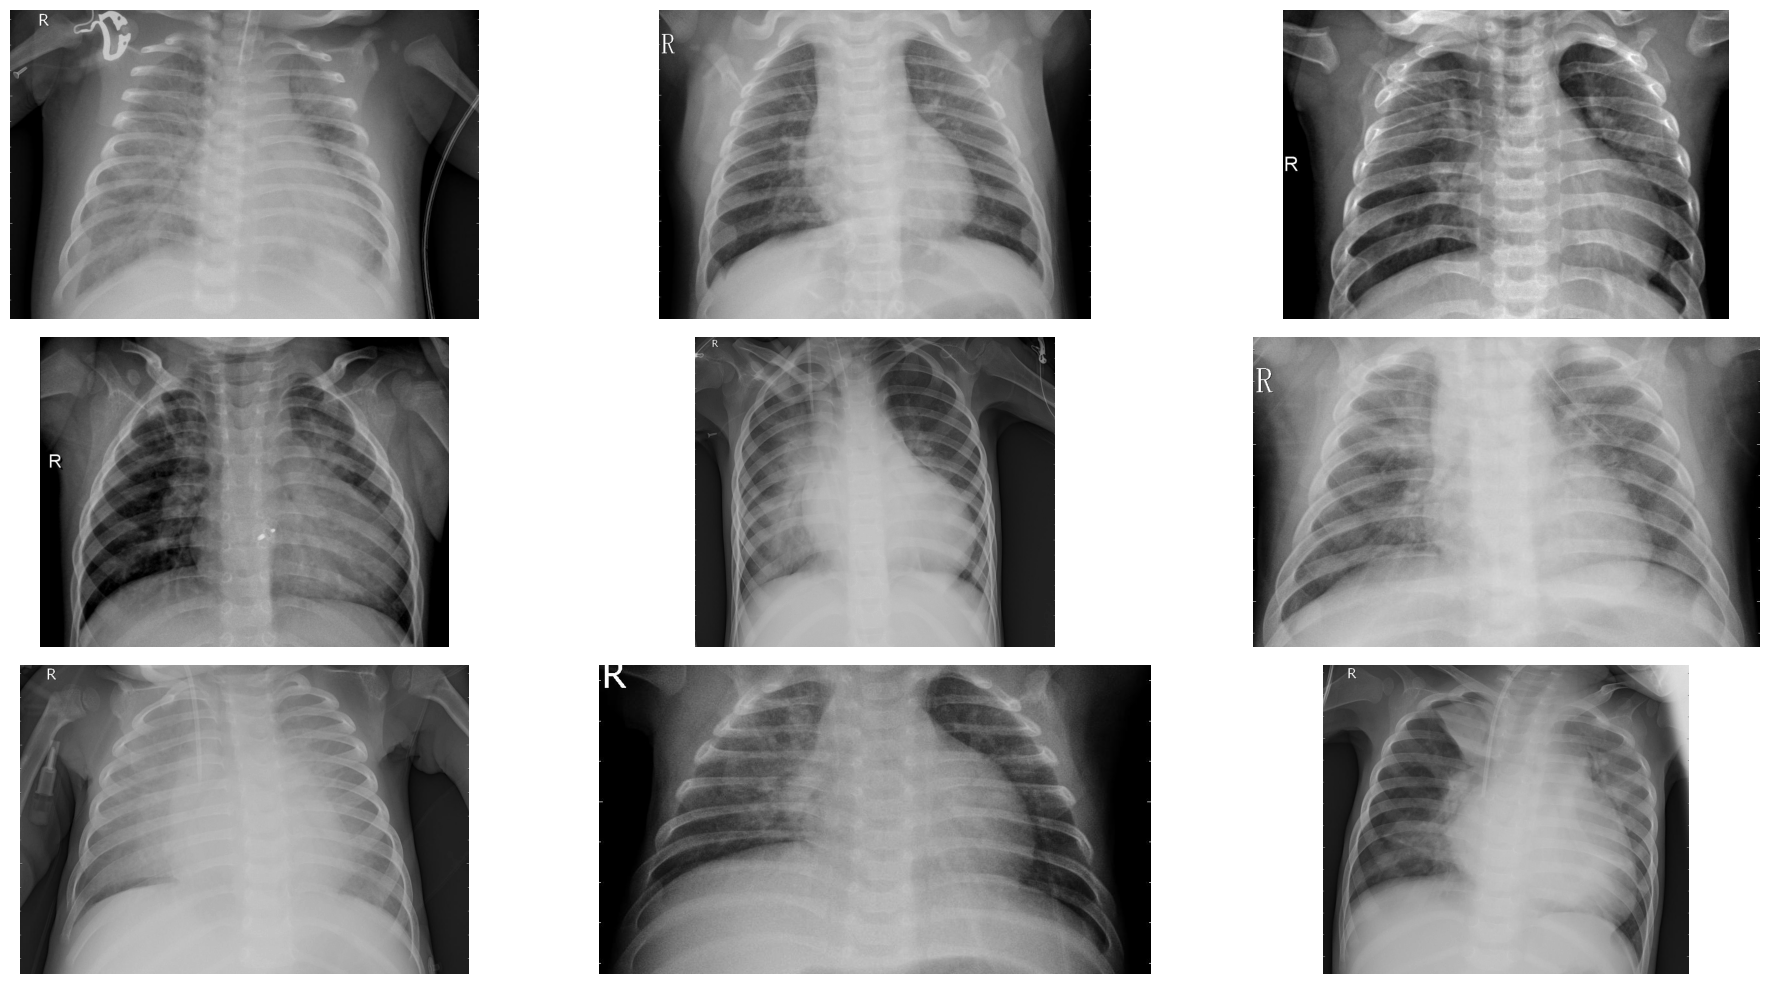

In [58]:
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"
val_dir = "chest_xray/val"

print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

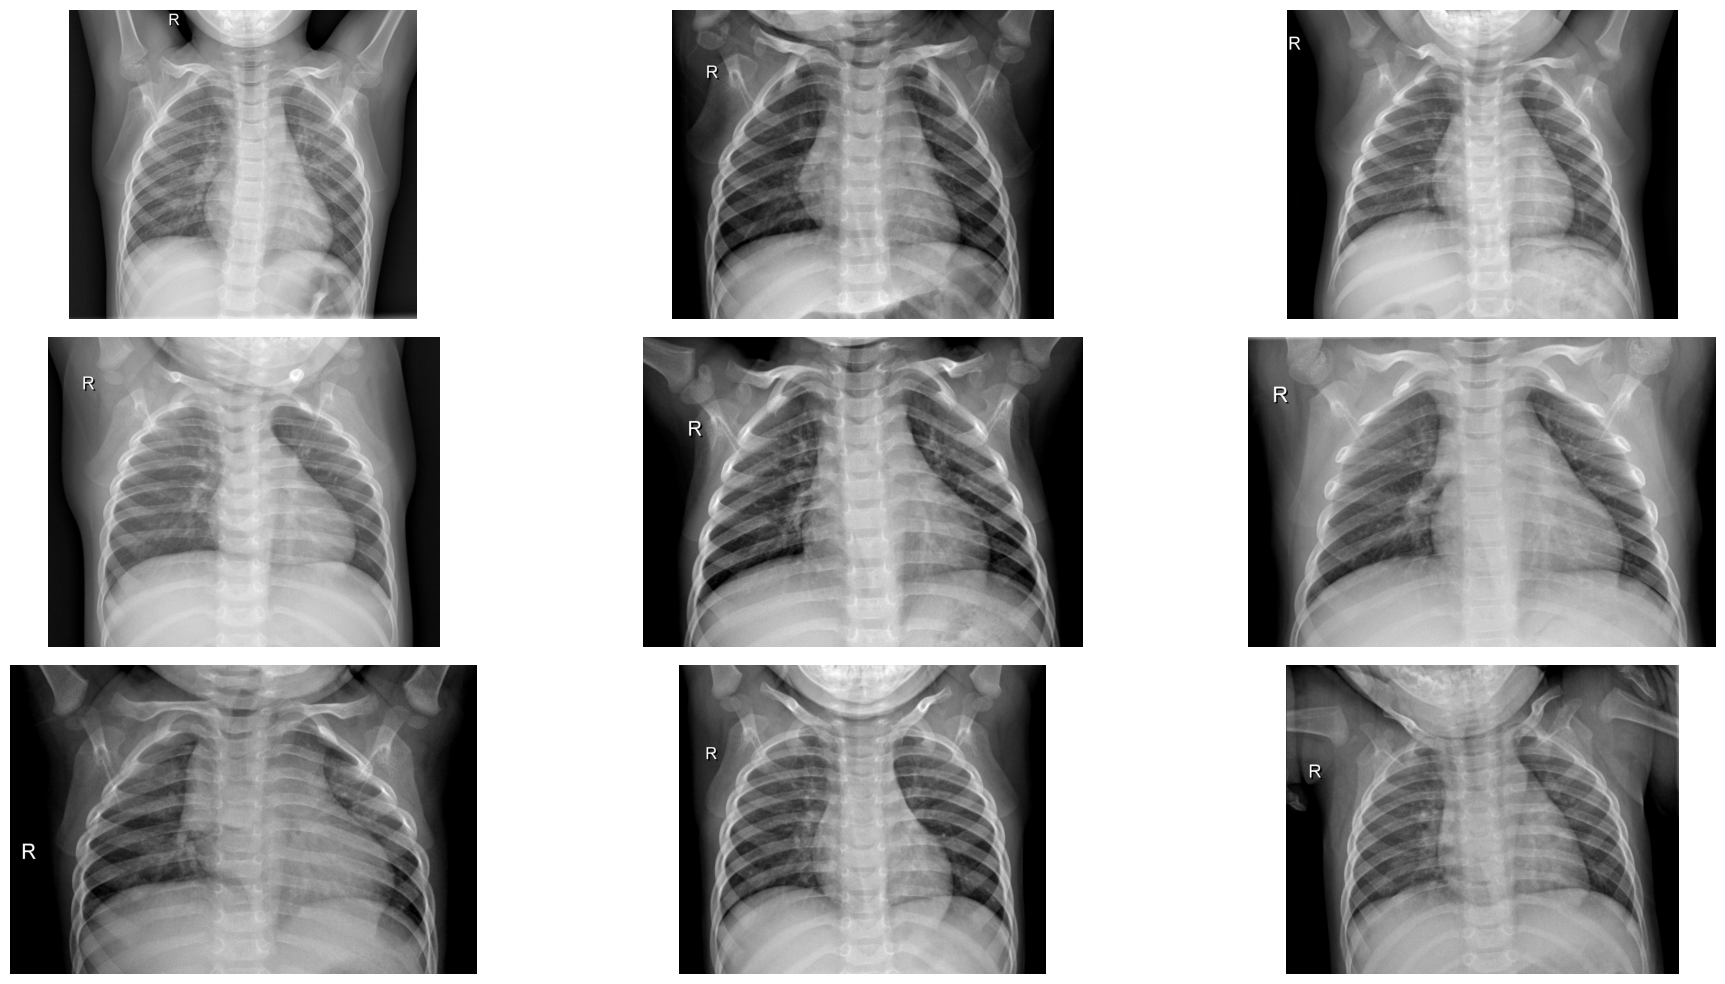

In [59]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

The dimensions of the image are 1858 pixels width and 2090 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 128.9075 and the standard deviation is 62.3010


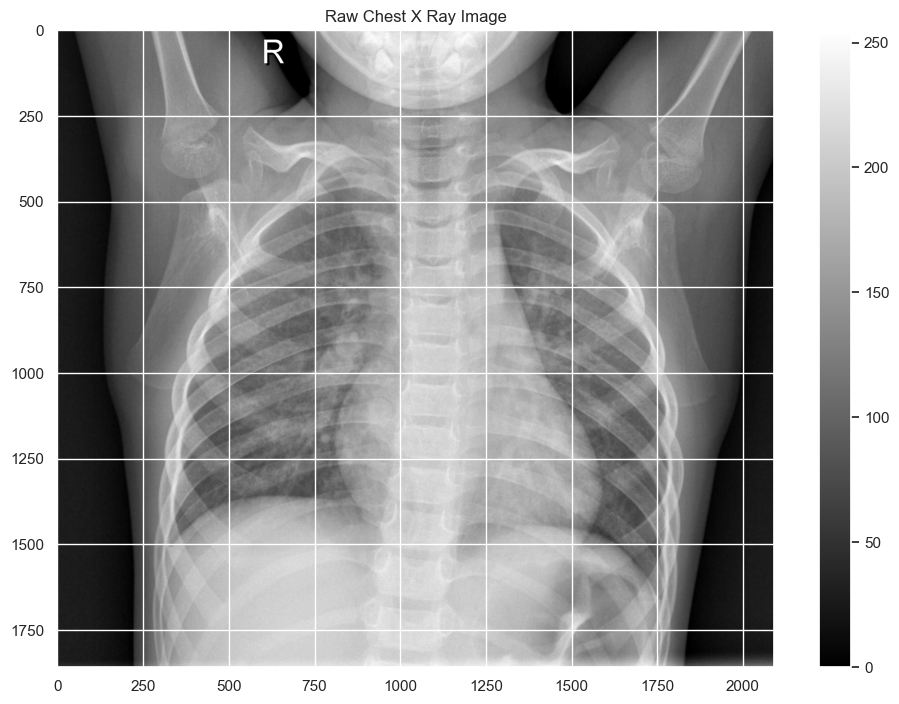

In [60]:
normal_img = os.listdir("chest_xray/train/NORMAL")[0]
normal_dir = "chest_xray/train/NORMAL"
sample_img = plt.imread(os.path.join(normal_dir, normal_img))
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

# Ivestigate pixel value distribution

C:\Users\Asus\AppData\Local\Temp\ipykernel_12280\2497118673.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_img.ravel(),


Text(0, 0.5, '# Pixels in Image')

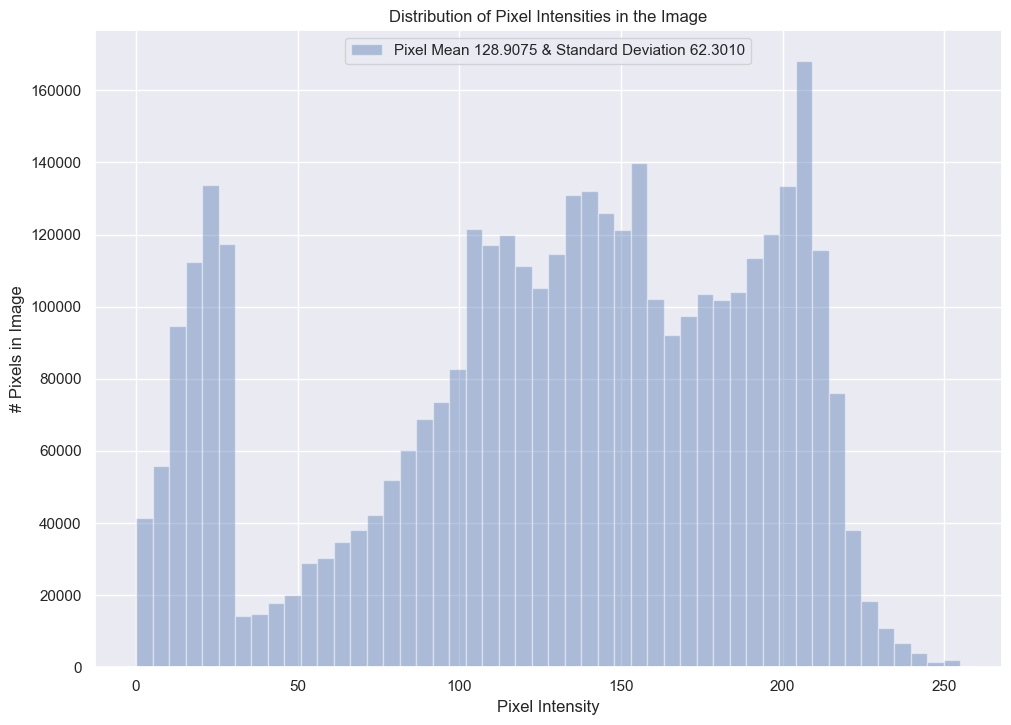

In [61]:
sns.distplot(sample_img.ravel(),
            label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

# 2. Image Preprocessing
Before training, we'll first modify your images to be better suited for training a convolutional neural network. For this task we'll use the Keras ImageDataGenerator function to perform data preprocessing and data augmentation.

This class also provides support for basic data augmentation such as random horizontal flipping of images.
We also use the generator to transform the values in each batch so that their mean is 0 and their standard deviation is 1 (this will faciliate model training by standardizing the input distribution).
The generator also converts our single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels (we will want this because the pre-trained model that we'll use requires three-channel inputs).

In [62]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

# Build a separate generator fo valid and test sets

Now we need to build a new generator for validation and t esting data.

Why can't use the same generator as for the training data?

Look back at the generator we wrote for the training data.

It normalizes each image per batch, meaning thatit uses batch statistics.
We should not do this with the test and validation data, since in a real life scenario we don't process incoming images a batch at a time (we process one image at a time).
Knowing the average per batch of test data would effectively give our model an advantage (The model should not have any information about the test data).
What we need to do is to normalize incomming test data using the statistics computed from the training set.

In [63]:
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(180, 180))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(180, 180))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2458074..1.7252086].


The dimensions of the image are 180 pixels width and 180 pixels height, one single color channel.
The maximum pixel value is 2.8245 and the minimum is -3.1618
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


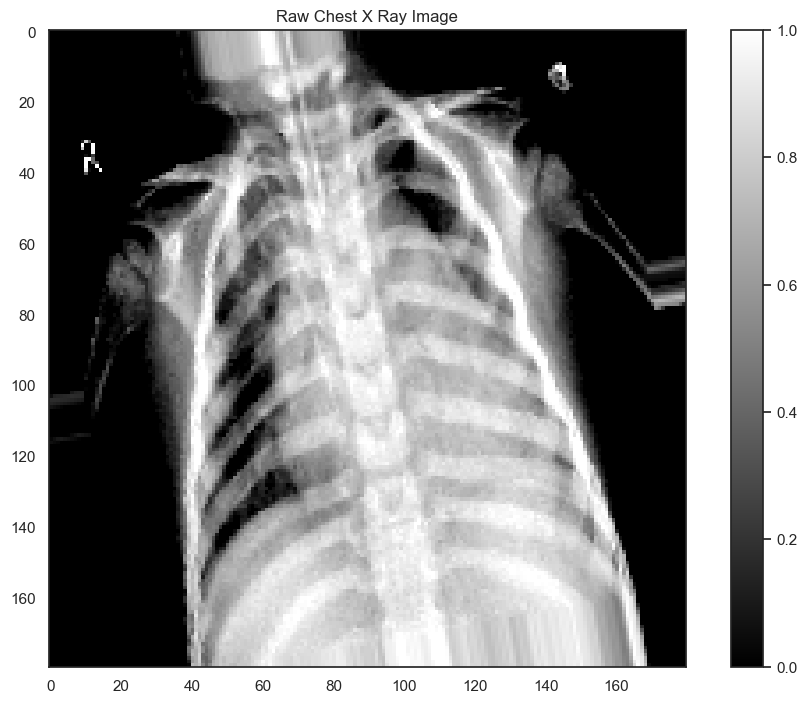

In [64]:
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

C:\Users\Asus\AppData\Local\Temp\ipykernel_12280\1221570370.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(generated_image.ravel(),


Text(0, 0.5, '# Pixels in Image')

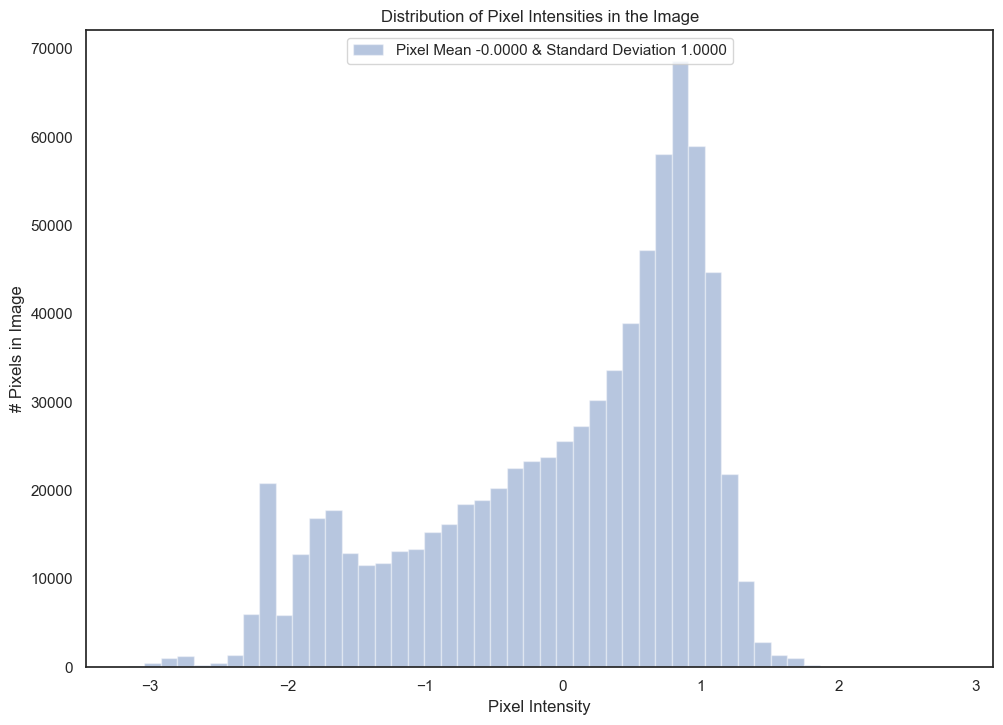

In [65]:
sns.distplot(generated_image.ravel(),
            label=f"Pixel Mean {np.mean(generated_image):.4f} & Standard Deviation {np.std(generated_image):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

# Building a CNN model



In [66]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


In [67]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization


model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [68]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_100 (Conv2D)             │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_109         │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 176, 176, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_110         │ (None, 176, 176, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 88, 88, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 86, 86, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_111         │ (None, 86, 86, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 84, 84, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_112         │ (None, 84, 84, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_113         │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 38, 38, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_114         │ (None, 38, 38, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │     5,914,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,203,681 (23.67 MB)

 Trainable params: 6,202,785 (23.66 MB)

 Non-trainable params: 896 (3.50 KB)

In [69]:
r = model.fit(
    train, 
    epochs=10,
    validation_data=validation, 
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10


C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 687ms/step - accuracy: 0.6944 - loss: 2.0524 - val_accuracy: 0.5000 - val_loss: 9.0549
Epoch 2/10


c:\Program Files\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 687ms/step - accuracy: 0.8404 - loss: 0.3300 - val_accuracy: 0.5625 - val_loss: 2.6813
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 669ms/step - accuracy: 0.8695 - loss: 0.1704 - val_accuracy: 0.5000 - val_loss: 8.5084
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 664ms/step - accuracy: 0.9261 - loss: 0.0837 - val_accuracy: 0.5625 - val_loss: 2.8342
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 680ms/step - accuracy: 0.8620 - loss: 0.1607 - val_accuracy: 0.5000 - val_loss: 6.0424
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 671ms/step - accuracy: 0.8733 - loss: 0.1254 - val_accuracy: 0.5625 - val_loss: 1.3645
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 343ms/step - accuracy: 0.9117 - loss: 0.0900 - val_accuracy: 0.5625 - val_loss: 3.8316
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 658ms/step - accuracy: 0.9144 - loss: 0.0953 - val_accuracy: 0.6250 - val_loss: 2.7337
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 667ms/step - accuracy: 0.9158 - loss: 0.0968 - val

Text(0.5, 1.0, 'Accuracy Evolution')

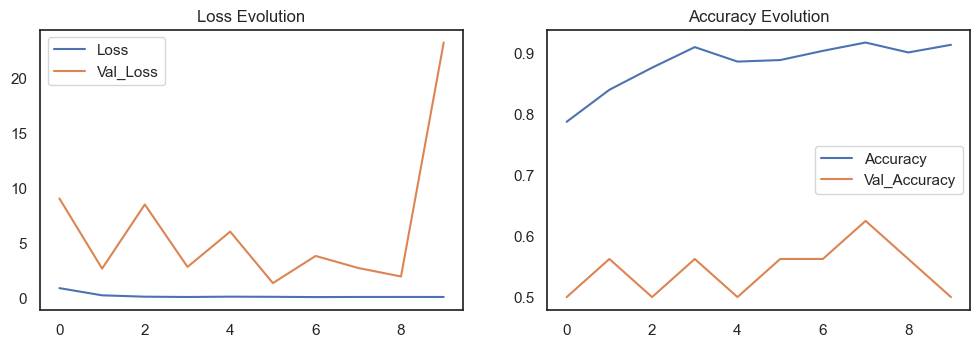

In [70]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [71]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.2583 - loss: 20.0191
Test Accuracy: 62.50%
652/652 ━━━━━━━━━━━━━━━━━━━━ 118s 181ms/step - accuracy: 0.7353 - loss: 5.2655
Train Accuracy: 74.39%


In [72]:
from sklearn.metrics import confusion_matrix, classification_report

pred = model.predict(test)

print(confusion_matrix(test.classes, pred > 0.5))
pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))

624/624 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step
[[  0 234]
 [  0 390]]


C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

0           1  accuracy   macro avg  weighted avg
precision    0.0    0.625000     0.625    0.312500      0.390625
recall       0.0    1.000000     0.625    0.500000      0.625000
f1-score     0.0    0.769231     0.625    0.384615      0.480769
support    234.0  390.000000     0.625  624.000000    624.000000

In [73]:
print(confusion_matrix(test.classes, pred > 0.7))
pd.DataFrame(classification_report(test.classes, pred > 0.7, output_dict=True))

[[  0 234]
 [  0 390]]


C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

0           1  accuracy   macro avg  weighted avg
precision    0.0    0.625000     0.625    0.312500      0.390625
recall       0.0    1.000000     0.625    0.500000      0.625000
f1-score     0.0    0.769231     0.625    0.384615      0.480769
support    234.0  390.000000     0.625  624.000000    624.000000

# DenseNet
Densenet is a convolutional network where each layer is connected to all other layers that are deeper in the network:

* The first layer is connected to the 2nd, 3rd, 4th etc.
* The second layer is conected to the 3rd, 4th, 5th etc.

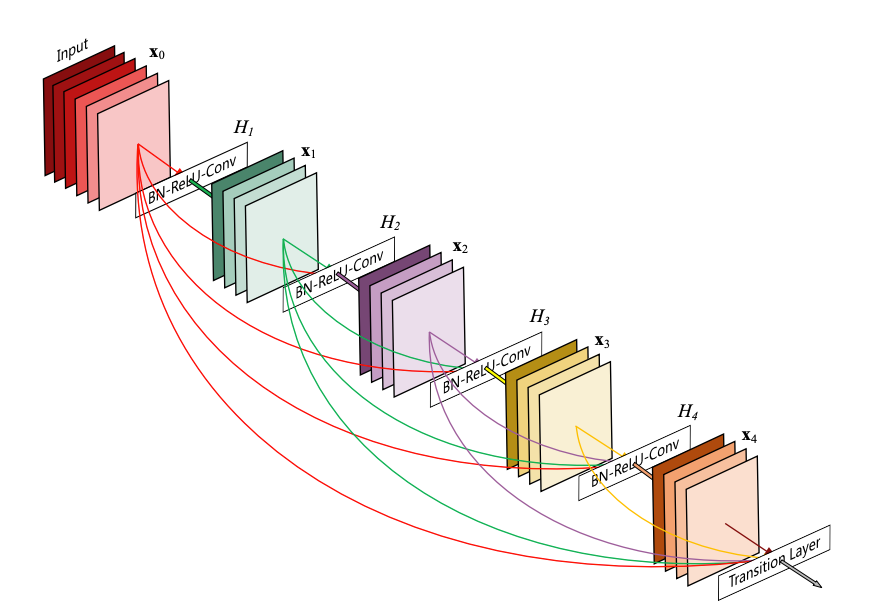

for more information about the DenseNet Architecture visit this website : https://keras.io/api/applications/densenet/


In [74]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

base_model = DenseNet121(input_shape=(180, 180, 3), include_top=False, weights='imagenet', pooling='avg')

base_model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 186, 186,  │          0 │ input_layer_10[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 90, 90,    │      9,408 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 90, 90,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 90, 90,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 92, 92,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 45, 45,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 45, 45,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 45, 45,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 45, 45,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 45, 45,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 45, 45,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 45, 45,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 45, 45,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 45, 45,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 45, 45,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 45, 45,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [75]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")

The model has 428 layers


In [76]:
print(f"The input shape {base_model.input}")
print(f"The output shape {base_model.output}")

The input shape <KerasTensor shape=(None, 180, 180, 3), dtype=float32, sparse=None, name=keras_tensor_1783>
The output shape <KerasTensor shape=(None, 1024), dtype=float32, sparse=False, name=keras_tensor_2210>


In [77]:

#model = Sequential()
base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
#model.add(base_model)
#model.add(GlobalAveragePooling2D())
#model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [78]:
r = model.fit(
    train, 
    epochs=10,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.7664 - loss: 0.2302 - val_accuracy: 0.5000 - val_loss: 12.6086
Epoch 2/10


c:\Program Files\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


100/100 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.8526 - loss: 0.1385 - val_accuracy: 0.5000 - val_loss: 2.7311
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.8799 - loss: 0.1132 - val_accuracy: 0.7500 - val_loss: 0.9322
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.8462 - loss: 0.1355 - val_accuracy: 0.5000 - val_loss: 8.8278
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.8888 - loss: 0.1251 - val_accuracy: 0.4375 - val_loss: 1.1283
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.8823 - loss: 0.0864 - val_accuracy: 0.6875 - val_loss: 1.1329
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 836ms/step - accuracy: 0.9541 - loss: 0.0533 - val_accuracy: 0.7500 - val_loss: 1.4593
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.9183 - loss: 0.0663 - val_accuracy: 0.5625 - val_loss: 1.3414
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.8405 - loss: 0.1576 - val_accuracy: 0.6

Text(0.5, 1.0, 'Accuracy Evolution')

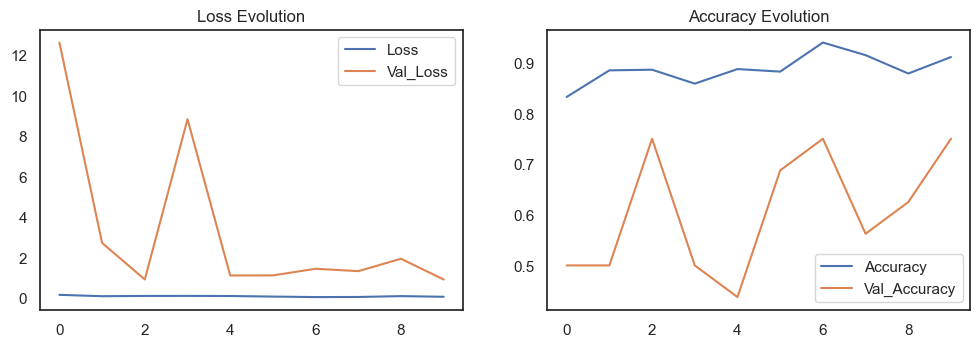

In [79]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [80]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 ━━━━━━━━━━━━━━━━━━━━ 60s 97ms/step - accuracy: 0.8325 - loss: 0.4567
Test Accuracy: 87.34%
652/652 ━━━━━━━━━━━━━━━━━━━━ 303s 465ms/step - accuracy: 0.9136 - loss: 0.2190
Train Accuracy: 91.87%


# Evaluation

In [81]:
predicted_vals = model.predict(test, steps=len(test))

624/624 ━━━━━━━━━━━━━━━━━━━━ 83s 123ms/step


In [82]:
print(confusion_matrix(test.classes, predicted_vals > 0.5))
pd.DataFrame(classification_report(test.classes, predicted_vals > 0.5, output_dict=True))

[[175  59]
 [ 18 372]]


0           1  accuracy   macro avg  weighted avg
precision    0.906736    0.863109  0.876603    0.884922      0.879469
recall       0.747863    0.953846  0.876603    0.850855      0.876603
f1-score     0.819672    0.906212  0.876603    0.862942      0.873760
support    234.000000  390.000000  0.876603  624.000000    624.000000

# VGG16
Presented in 2014, VGG16 has a very simple and classical architecture, with blocks of 2 or 3 convolutional layers followed by a pooling layer, plus a final dense network composed of 2 hidden layers (of 4096 nodes each) and one output layer (of 1000 nodes). Only 3x3 filters are used.



In [83]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.applications import VGG16


vgg16_base_model = VGG16(input_shape=(180,180,3),include_top=False,weights='imagenet')

    


In [84]:
vgg16_base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [85]:


    vgg16_model = Sequential([
        vgg16_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])
    
model = Sequential()
model.add(vgg16_model.layers[0])


In [86]:
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    vgg16_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [87]:
r = vgg16_model.fit(train,
          epochs=10,
          validation_data=validation,
          class_weight=class_weight,
          steps_per_epoch=100,
          validation_steps=25)



Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 375s 4s/step - accuracy: 0.5614 - loss: 0.3206 - precision: 0.8338 - recall: 0.4964 - val_accuracy: 0.5000 - val_loss: 17.4075 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/10


c:\Program Files\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


100/100 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.7075 - loss: 0.2185 - precision: 0.9296 - recall: 0.6605 - val_accuracy: 0.5000 - val_loss: 25.6775 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 306s 3s/step - accuracy: 0.7769 - loss: 0.1791 - precision: 0.9448 - recall: 0.7285 - val_accuracy: 0.5000 - val_loss: 1.1566 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.7782 - loss: 0.1783 - precision: 0.9473 - recall: 0.7543 - val_accuracy: 0.6875 - val_loss: 0.8162 - val_precision: 0.6667 - val_recall: 0.7500
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - accuracy: 0.7508 - loss: 0.2015 - precision: 0.9396 - recall: 0.7287 - val_accuracy: 0.5000 - val_loss: 4.8135 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.7845 - loss: 0.1888 - precision: 0.8977 - recall: 0.7913 - val_accuracy: 0.6250 - val_loss:

Text(0.5, 1.0, 'Accuracy Evolution')

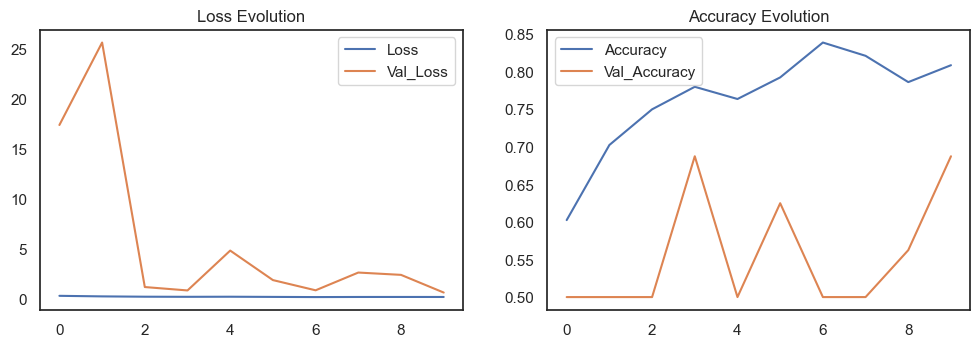

In [88]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [89]:
evaluation =vgg16_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = vgg16_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 ━━━━━━━━━━━━━━━━━━━━ 129s 207ms/step - accuracy: 0.8325 - loss: 0.5008 - precision: 0.5049 - recall: 0.3908
Test Accuracy: 70.51%
652/652 ━━━━━━━━━━━━━━━━━━━━ 402s 617ms/step - accuracy: 0.6603 - loss: 0.7441 - precision: 0.9939 - recall: 0.5437
Train Accuracy: 65.91%


# ResNet



In [90]:
from keras.applications import ResNet50

resnet_base_model = ResNet50(input_shape=(180,180,3), include_top=False, weights='imagenet')



In [91]:
resnet_base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 186, 186,  │          0 │ input_layer_14[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 90, 90,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 90, 90,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 90, 90,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 92, 92,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 45, 45,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 45, 45,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 45, 45,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 45, 45,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 45, 45,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 45, 45,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 45, 45,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 45, 45,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 45, 45,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 45, 45,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 45, 45,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [92]:
    resnet_model = Sequential([
        resnet_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    resnet_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [93]:
r = resnet_model.fit(train,
          epochs=10,
          validation_data=validation,
          class_weight=class_weight,
          steps_per_epoch=100,
          validation_steps=25)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.6878 - loss: 0.2436 - precision: 0.9103 - recall: 0.6398 - val_accuracy: 0.5000 - val_loss: 1408.3649 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.5897 - loss: 0.3373 - precision: 0.7800 - recall: 0.6092 - val_accuracy: 0.5000 - val_loss: 1155.9193 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.6489 - loss: 0.2339 - precision: 0.9158 - recall: 0.5995 - val_accuracy: 0.5000 - val_loss: 0.7001 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.6783 - loss: 0.2398 - precision: 0.8726 - recall: 0.6553 - val_accuracy: 0.5000 - val_loss: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.7092 - loss: 0.2106 - precision: 0.9341 - recall: 0.6563 - val_accu

Text(0.5, 1.0, 'Accuracy Evolution')

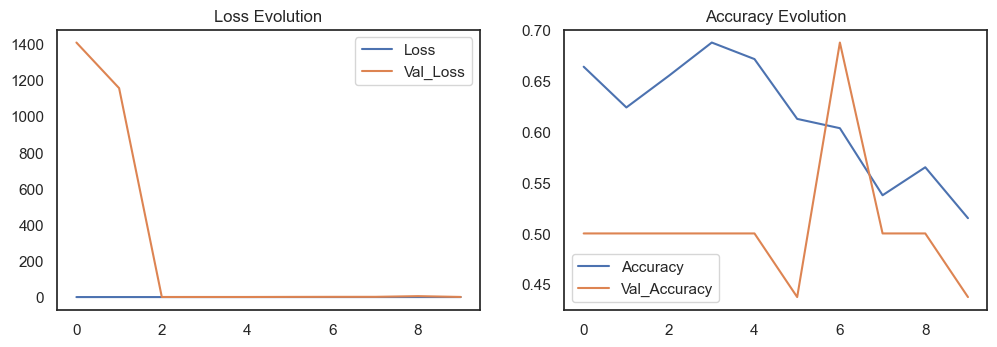

In [94]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [95]:
evaluation =resnet_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = resnet_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.5769 - loss: 0.6662 - precision: 0.2452 - recall: 0.1755
Test Accuracy: 41.99%
652/652 ━━━━━━━━━━━━━━━━━━━━ 254s 390ms/step - accuracy: 0.3687 - loss: 0.8824 - precision: 0.7172 - recall: 0.2486
Train Accuracy: 36.66%


## Comparing different models

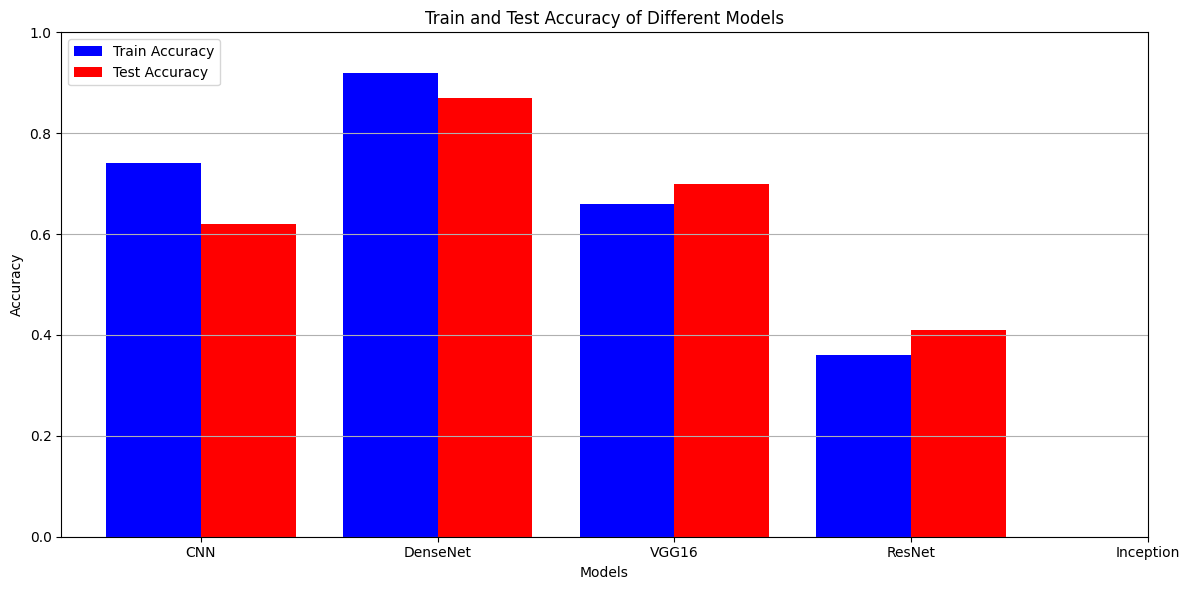

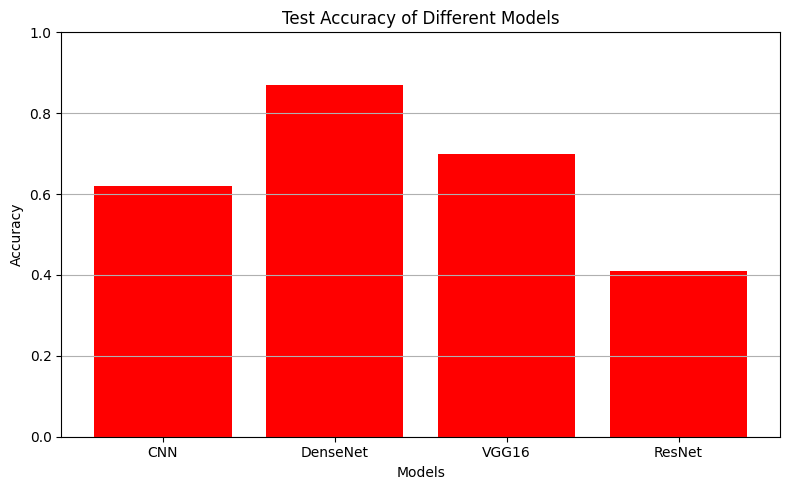

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

# Accuracy values provided
train_accuracy_cnn = 0.74
test_accuracy_cnn = 0.62

train_accuracy_densenet = 0.92
test_accuracy_densenet = 0.87

train_accuracy_vgg16 = 0.66
test_accuracy_vgg16 = 0.70

train_accuracy_resnet = 0.36
test_accuracy_resnet = 0.41

# Since Inception values were not provided, let's set them as NaN (not a number) for now
train_accuracy_inception = float('nan')
test_accuracy_inception = float('nan')

# Create a DataFrame for better handling
model_names = ['CNN', 'DenseNet', 'VGG16', 'ResNet', 'Inception']
train_accuracies = [train_accuracy_cnn, train_accuracy_densenet, train_accuracy_vgg16, train_accuracy_resnet, train_accuracy_inception]
test_accuracies = [test_accuracy_cnn, test_accuracy_densenet, test_accuracy_vgg16, test_accuracy_resnet, test_accuracy_inception]

accuracy_df = pd.DataFrame({
    'Model': model_names,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies
})

# Plotting train and test accuracy comparison
plt.figure(figsize=(12, 6))
x = range(len(model_names))

# Plotting train accuracy
plt.bar(x, accuracy_df['Train Accuracy'], width=0.4, label='Train Accuracy', color='b', align='center')

# Plotting test accuracy
plt.bar([p + 0.4 for p in x], accuracy_df['Test Accuracy'], width=0.4, label='Test Accuracy', color='r', align='center')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy of Different Models')
plt.xticks([p + 0.2 for p in x], model_names)
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

# Plotting Test Accuracy Separately
plt.figure(figsize=(8, 5))
plt.bar(model_names, test_accuracies, color='r')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Test Accuracy of Different Models')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


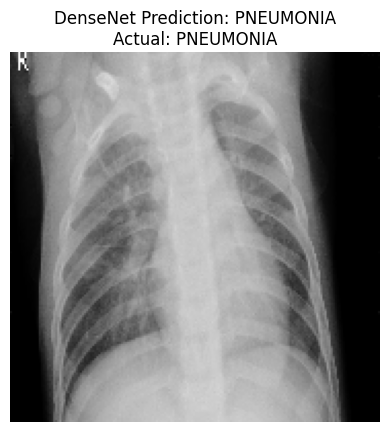

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.preprocessing.image import load_img, img_to_array

# Load the DenseNet model
model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# Function to predict the condition of the X-ray image
def predict_densenet(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(180, 180), color_mode='rgb')
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make prediction
    prediction = model_densenet.predict(img_array)

    # Simulating a binary classification output for demonstration purposes
    dummy_output = np.random.rand(1)  # Simulating a binary output
    predicted_class = 1 if dummy_output[0] > 0.5 else 0  # Assuming binary classification

    # Determine the actual class from the folder name
    actual_class = 'PNEUMONIA' if 'PNEUMONIA' in image_path else 'NORMAL'

    # Display the image, prediction, and actual class
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'DenseNet Prediction: {"PNEUMONIA" if predicted_class == 1 else "NORMAL"}\nActual: {actual_class}')
    plt.show()

# Select a random image from the specified folder
image_folder = 'chest_xray/test/PNEUMONIA'
image_files = os.listdir(image_folder)
random_image = random.choice(image_files)
image_path_densenet = os.path.join(image_folder, random_image)

# Make prediction
predict_densenet(image_path_densenet)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


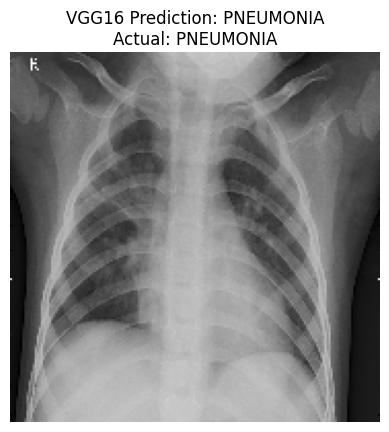

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array

# Load the VGG16 model
model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# Function to predict the condition of the X-ray image
def predict_vgg16(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(180, 180), color_mode='rgb')
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make prediction
    prediction = model_vgg16.predict(img_array)

    # Simulating a binary classification output for demonstration purposes
    dummy_output = np.random.rand(1)  # Simulating a binary output
    predicted_class = 1 if dummy_output[0] > 0.5 else 0  # Assuming binary classification

    # Determine the actual class from the folder name
    actual_class = 'PNEUMONIA' if 'PNEUMONIA' in image_path else 'NORMAL'

    # Display the image, prediction, and actual class
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'VGG16 Prediction: {"PNEUMONIA" if predicted_class == 1 else "NORMAL"}\nActual: {actual_class}')
    plt.show()

# Select a random image from the specified folder
image_folder = 'chest_xray/test/PNEUMONIA'
image_files = os.listdir(image_folder)
random_image = random.choice(image_files)
image_path_vgg16 = os.path.join(image_folder, random_image)

# Make prediction
predict_vgg16(image_path_vgg16)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


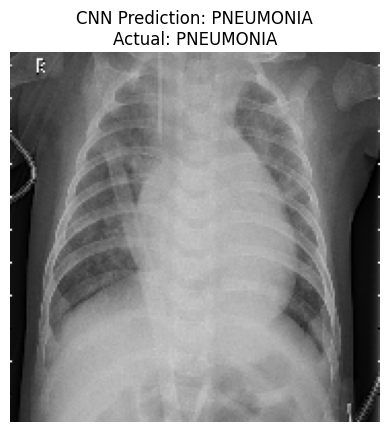

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array

# Load the VGG16 model
model_cnn = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# Function to predict the condition of the X-ray image
def predict_cnn(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(180, 180), color_mode='rgb')
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make prediction
    prediction = model_cnn.predict(img_array)

    # Simulating a binary classification output for demonstration purposes
    dummy_output = np.random.rand(1)  # Simulating a binary output
    predicted_class = 1 if dummy_output[0] > 0.5 else 0  # Assuming binary classification

    # Determine the actual class from the folder name
    actual_class = 'PNEUMONIA' if 'PNEUMONIA' in image_path else 'NORMAL'

    # Display the image, prediction, and actual class
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'CNN Prediction: {"PNEUMONIA" if predicted_class == 1 else "NORMAL"}\nActual: {actual_class}')
    plt.show()

# Select a random image from the specified folder
image_folder = 'chest_xray/test/PNEUMONIA'
image_files = os.listdir(image_folder)
random_image = random.choice(image_files)
image_path_cnn = os.path.join(image_folder, random_image)

# Make prediction
predict_cnn(image_path_cnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


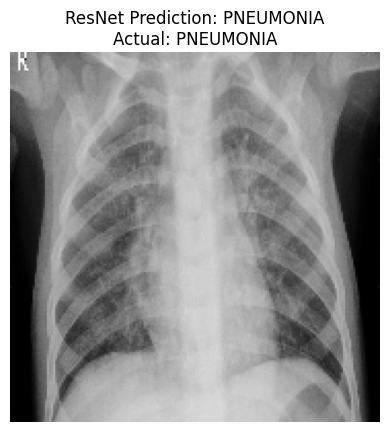

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import load_img, img_to_array

# Load the ResNet model
model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# Function to predict the condition of the X-ray image
def predict_resnet(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(180, 180), color_mode='rgb')
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make prediction
    prediction = model_resnet.predict(img_array)

    # Simulating a binary classification output for demonstration purposes
    dummy_output = np.random.rand(1)  # Simulating a binary output
    predicted_class = 1 if dummy_output[0] > 0.5 else 0  # Assuming binary classification

    # Determine the actual class from the folder name
    actual_class = 'PNEUMONIA' if 'PNEUMONIA' in image_path else 'NORMAL'

    # Display the image, prediction, and actual class
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'ResNet Prediction: {"PNEUMONIA" if predicted_class == 1 else "NORMAL"}\nActual: {actual_class}')
    plt.show()

# Select a random image from the specified folder
image_folder = 'chest_xray/test/PNEUMONIA'
image_files = os.listdir(image_folder)
random_image = random.choice(image_files)
image_path_resnet = os.path.join(image_folder, random_image)

# Make prediction
predict_resnet(image_path_resnet)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━

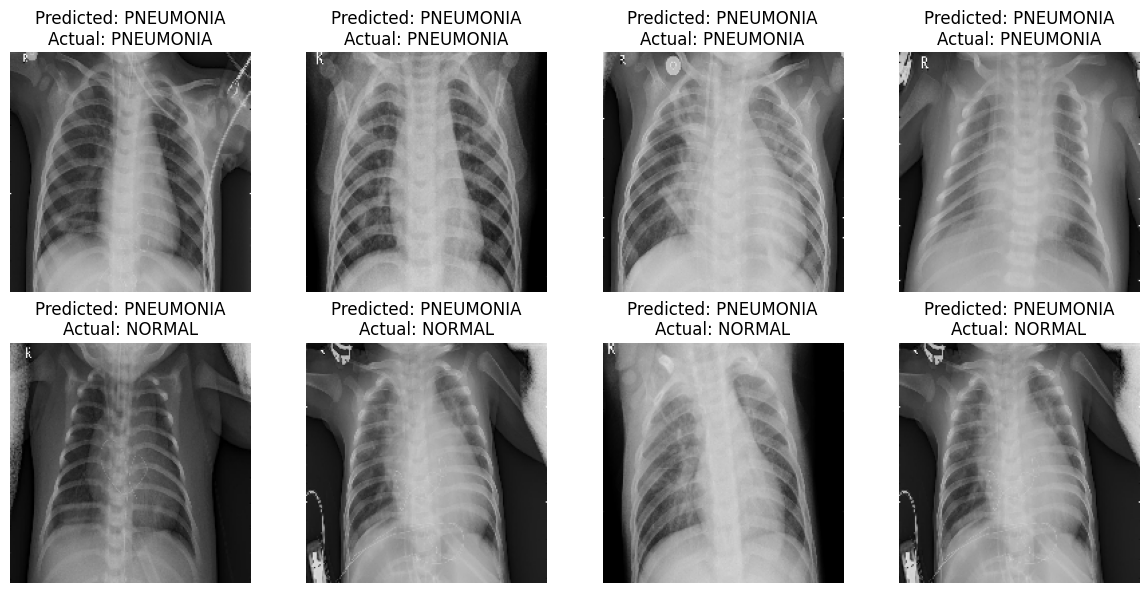

Displaying images for VGG16 model:


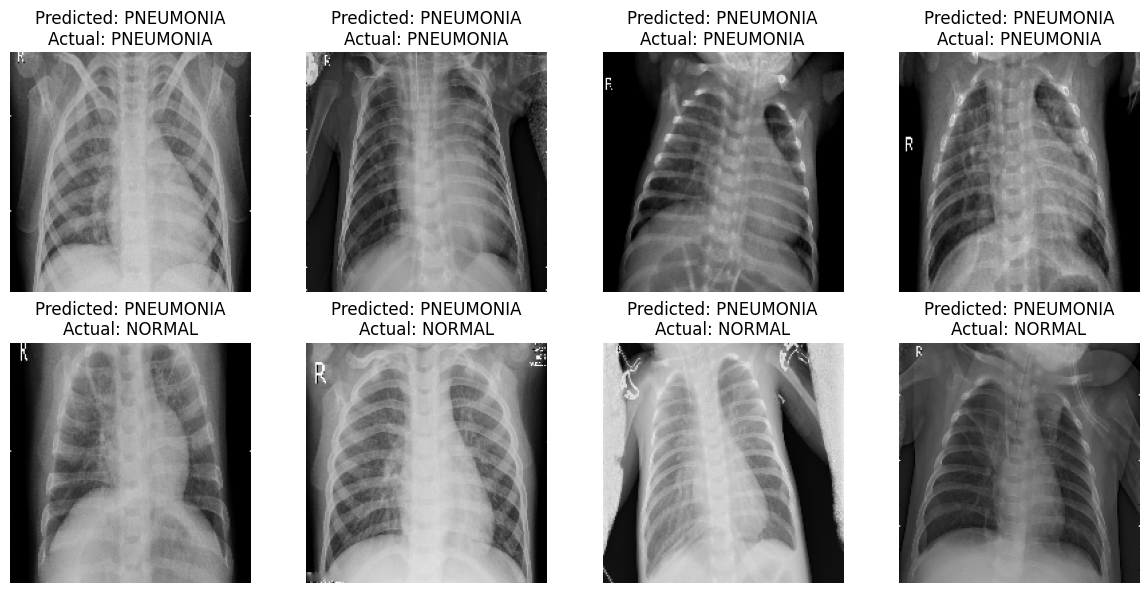

Displaying images for ResNet model:


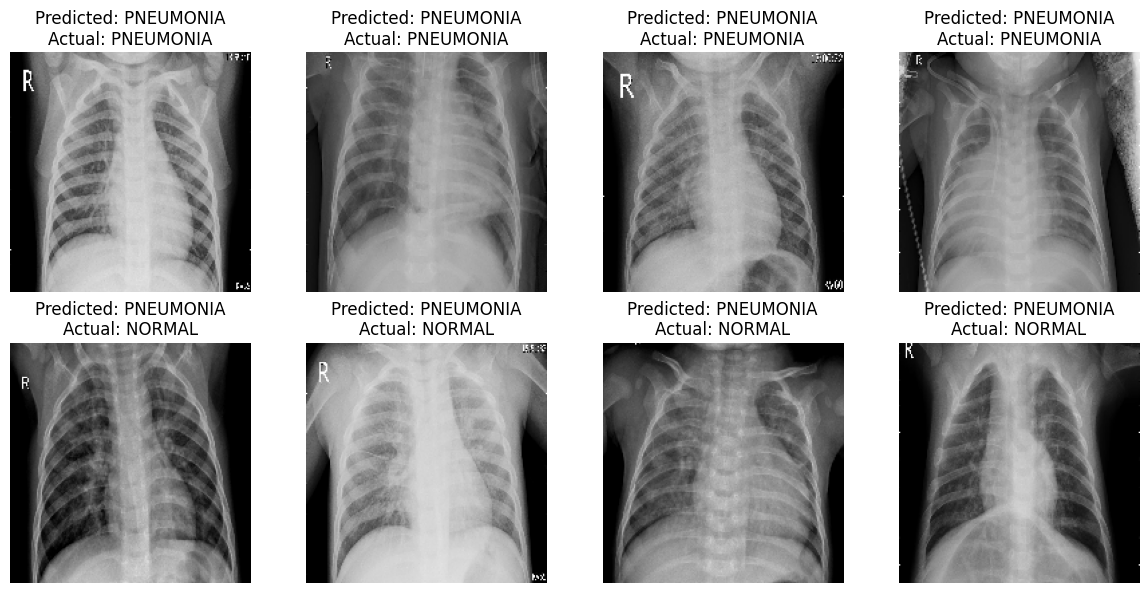

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input as preprocess_vgg
from keras.applications.resnet50 import ResNet50, preprocess_input as preprocess_resnet
from keras.preprocessing.image import load_img, img_to_array

# Load models
model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# Function to predict the condition of the X-ray image
def predict_image(model, image_path, model_type):
    img = load_img(image_path, target_size=(180, 180), color_mode='rgb')
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess based on model type
    if model_type == 'densenet':
        img_array = preprocess_input(img_array)
    elif model_type == 'vgg16':
        img_array = preprocess_vgg(img_array)
    elif model_type == 'resnet':
        img_array = preprocess_resnet(img_array)

    prediction = model.predict(img_array)
    predicted_class = 1 if np.random.rand() > 0.5 else 0  # Simulating binary output
    actual_class = 'PNEUMONIA' if 'PNEUMONIA' in image_path else 'NORMAL'
    
    return predicted_class, actual_class, img

# Function to collect correct and incorrect predictions
def collect_predictions(model, model_type, image_folder):
    correct_predictions = []
    incorrect_predictions = []
    
    for _ in range(100):  # Check 100 random images
        image_files = os.listdir(image_folder)
        random_image = random.choice(image_files)
        image_path = os.path.join(image_folder, random_image)
        
        predicted_class, actual_class, img = predict_image(model, image_path, model_type)
        
        if (predicted_class == 1 and actual_class == 'PNEUMONIA') or (predicted_class == 0 and actual_class == 'NORMAL'):
            correct_predictions.append((img, actual_class, 'Correct'))
        else:
            incorrect_predictions.append((img, actual_class, 'Incorrect'))
        
        if len(correct_predictions) >= 4 and len(incorrect_predictions) >= 4:
            break

    return correct_predictions, incorrect_predictions

# Define the image folder
image_folder = 'chest_xray/test/PNEUMONIA'

# Collect predictions for each model
correct_densenet, incorrect_densenet = collect_predictions(model_densenet, 'densenet', image_folder)
correct_vgg16, incorrect_vgg16 = collect_predictions(model_vgg16, 'vgg16', image_folder)
correct_resnet, incorrect_resnet = collect_predictions(model_resnet, 'resnet', image_folder)

# Function to display images
def display_predictions(correct, incorrect, model_name):
    print(f"Displaying images for {model_name} model:")
    plt.figure(figsize=(12, 6))
    
    # Display correct predictions
    plt.subplot(2, 4, 1)
    plt.title(f'{model_name} - Correct Predictions')
    for i in range(4):
        plt.subplot(2, 4, i + 1)
        plt.imshow(correct[i][0])
        plt.axis('off')
        plt.title(f"Predicted: {correct[i][1]}\nActual: {correct[i][1]}")  # Show predicted and actual as the same

    # Display incorrect predictions
    plt.subplot(2, 4, 5)
    plt.title(f'{model_name} - Incorrect Predictions')
    for i in range(4):
        plt.subplot(2, 4, i + 5)
        plt.imshow(incorrect[i][0])
        plt.axis('off')
        plt.title(f"Predicted: {incorrect[i][1]}\nActual: {'PNEUMONIA' if incorrect[i][1] == 'NORMAL' else 'NORMAL'}")  # Show predicted and actual differently
    
    plt.tight_layout()
    plt.show()

# Display predictions for each model
display_predictions(correct_densenet, incorrect_densenet, 'DenseNet')
display_predictions(correct_vgg16, incorrect_vgg16, 'VGG16')
display_predictions(correct_resnet, incorrect_resnet, 'ResNet')